In [87]:
import pandas as pd
import scipy.stats
import numpy as np
import datetime as dt
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
start_time = dt.datetime.now()

In [88]:
data = pd.read_csv('card transactions after cleaning.csv')

In [89]:
#data = data.astype(str)
data['Date'] = pd.to_datetime(data['Date'])

In [90]:
#BUILD VARIABLE 
import time
import calendar
#Day of Week Target Encoding
data['dow']=data.Date.apply(lambda x: calendar.day_name[x.weekday()])
# Separate the OOT
train_set=data[data.Date<'2010-11-01']

In [91]:
#Statistical Smoothing
c=4;nmid=20;y_avg=train_set['Fraud'].mean()
y_dow=train_set.groupby('dow')['Fraud'].mean()
num=train_set.groupby('dow').size()
y_dow_smooth=y_avg+(y_dow-y_avg)/(1+np.exp(-(num-nmid)/c))
data['dow_risk']=data.dow.map(y_dow_smooth)

In [92]:
# delete files that we don't need any more to free up memory
del train_set

In [93]:
y_dow=y_dow.reset_index()
cats=['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
y_dow['dow']=pd.Categorical(y_dow['dow'],categories=cats,ordered=True)
y_dow=y_dow.sort_values('dow')
y_dow=y_dow.set_index('dow')

In [94]:
data['Cardnum'] = data['Cardnum'].astype(str)
data['Merch zip'] = data['Merch zip'].astype(str)
data['Amount'] = data['Amount'].astype(str)
data['Date'] = pd.to_datetime(data['Date'])


In [95]:
# Make new entities for variables
data['cardnum_merchnum']= data.Cardnum + data.Merchnum
data['cardnum_merchzip']= data['Cardnum'] +data['Merch zip']
data['cardnum_merchdescription']=data['Cardnum'] +data['Merch description']
data['cardnum_merchstate']=data['Cardnum']+data['Merch state']
data['merchnum_merchstate']=data.Merchnum+data['Merch state']
data['merchnum_merchdescription']=data.Merchnum+data['Merch description']
data['cardnum_amount']=data.Cardnum+data.Amount
data['merchnum_cardnum_amount']=data.Merchnum+data.cardnum_amount



In [96]:
data.columns
data['Amount'] = data['Amount'].astype(float)

In [97]:
attributes=list(data.iloc[:,np.r_[1, 3, 4, 5, 6, 12:20]].columns)

In [98]:
attributes

['Cardnum',
 'Merchnum',
 'Merch description',
 'Merch state',
 'Merch zip',
 'cardnum_merchnum',
 'cardnum_merchzip',
 'cardnum_merchdescription',
 'cardnum_merchstate',
 'merchnum_merchstate',
 'merchnum_merchdescription',
 'cardnum_amount',
 'merchnum_cardnum_amount']

In [99]:
# Create variables
df=data.copy()
final=data.copy()
df['check_date']=df.Date
df['check_record']=df.Recnum
numvars = 1
final.shape

(96397, 20)

In [100]:
begin = time.time()
for entity in attributes:
  st = time.time()
## Day-since variables:   
  df_l = df[['Recnum', 'Date', entity]]
  df_r = df[['check_record', 'check_date', entity, 'Amount']]
  temp = pd.merge(df_l, df_r, left_on = entity, right_on = entity)
  temp1 = temp[temp.Recnum > temp.check_record][['Recnum','Date','check_date']].groupby('Recnum')[['Date', 'check_date']].last()
  mapper = (temp1.Date - temp1.check_date).dt.days
  final[entity + '_day_since'] = final.Recnum.map(mapper)
  final[entity + '_day_since'].fillna((final.Date - pd.to_datetime('2010-01-01')).dt.days, inplace = True)
  print('\n' + entity + '_day_since ---> Done') 
## Frequency & Amount variables:   
  for t in [0,1,3,7,14,30]:
    temp2 = temp[(temp.check_date >= (temp.Date - dt.timedelta(t)))&(temp.Recnum >= temp.check_record)][['Recnum', entity, 'Amount']] 
    col_name = entity + '_count_' + str(t)
    mapper2 = temp2.groupby('Recnum')[entity].count()
    final[col_name] = final.Recnum.map(mapper2)
    print(col_name + ' ---> Done')
    final[entity + '_avg_' + str(t)] = final.Recnum.map(temp2.groupby('Recnum')['Amount'].mean())
    final[entity + '_max_' + str(t)] = final.Recnum.map(temp2.groupby('Recnum')['Amount'].max())
    final[entity + '_med_' + str(t)] = final.Recnum.map(temp2.groupby('Recnum')['Amount'].median())
    final[entity + '_total_' + str(t)] = final.Recnum.map(temp2.groupby('Recnum')['Amount'].sum())
    final[entity + '_actual/avg_' + str(t)] = final['Amount'] / final[entity + '_avg_' + str(t)]
    final[entity + '_actual/max_' + str(t)] = final['Amount'] / final[entity + '_max_' + str(t)]
    final[entity + '_actual/med_' + str(t)] = final['Amount'] / final[entity + '_med_' + str(t)]
    final[entity + '_actual/toal_' + str(t)] = final['Amount'] / final[entity + '_total_' + str(t)]
    print(entity + ' amount variables over past ' + str(t) + ' ---> Done')
#print(f'Run time for entity {entity}--------{time.time()-st:0.2f}s')
#print(f'Total run time:{(time.time()-begin)/60:0.2f}min')



Cardnum_day_since ---> Done
Cardnum_count_0 ---> Done
Cardnum amount variables over past 0 ---> Done
Cardnum_count_1 ---> Done
Cardnum amount variables over past 1 ---> Done
Cardnum_count_3 ---> Done
Cardnum amount variables over past 3 ---> Done
Cardnum_count_7 ---> Done
Cardnum amount variables over past 7 ---> Done
Cardnum_count_14 ---> Done
Cardnum amount variables over past 14 ---> Done
Cardnum_count_30 ---> Done
Cardnum amount variables over past 30 ---> Done

Merchnum_day_since ---> Done
Merchnum_count_0 ---> Done
Merchnum amount variables over past 0 ---> Done
Merchnum_count_1 ---> Done
Merchnum amount variables over past 1 ---> Done
Merchnum_count_3 ---> Done
Merchnum amount variables over past 3 ---> Done
Merchnum_count_7 ---> Done
Merchnum amount variables over past 7 ---> Done
Merchnum_count_14 ---> Done
Merchnum amount variables over past 14 ---> Done
Merchnum_count_30 ---> Done
Merchnum amount variables over past 30 ---> Done

Merch description_day_since ---> Done
Merch 

In [101]:
numvars_new = len(final.columns)- 19 - numvars
numvars = len(final.columns) - 19
print("new variables:",numvars_new,"  total variables:",numvars)

new variables: 715   total variables: 716


In [102]:
begin = time.time()
# velocity change variables
for ent in attributes:
  for d in ['0', '1']:
    for dd in ['7', '14', '30']:
      final[ent + '_count_' + d + '_by_' + dd] = final[ent + '_count_' + d]/(final[ent + '_count_' + dd])/float(dd)

In [103]:
numvars_new = len(final.columns)- 19 - numvars
numvars = len(final.columns) - 19
print("new variables:",numvars_new,"  total variables:",numvars)

new variables: 78   total variables: 794


In [104]:
begin = time.time()
# velocity days since ratio
for ent in attributes:
  for d in ['0', '1']:
    for dd in ['7', '14', '30']:
      final[ent + '_vdratio_' + d ] = final[ent + '_count_' + d + '_by_' + dd]/(final[ent + '_day_since']+1)

In [105]:
numvars_new = len(final.columns)- 19 - numvars
numvars = len(final.columns) - 19
print("new variables:",numvars_new,"  total variables:",numvars)

new variables: 26   total variables: 820


In [106]:
# Cross entity uniqueness variables
for entity in attributes: 
  for field in attributes:
    begin = time.time()
    if entity != field:
      new_attributes = f'{entity}_{field}_nunique'
      if new_attributes not in list(final.columns):
        mapper3 = final.groupby(entity)[field].nunique()
        final[new_attributes] = final[entity].map(mapper3)
    print(f'Run time for entity {entity} in field {field}'+ ' ---> Done')

Run time for entity Cardnum in field Cardnum ---> Done
Run time for entity Cardnum in field Merchnum ---> Done
Run time for entity Cardnum in field Merch description ---> Done
Run time for entity Cardnum in field Merch state ---> Done
Run time for entity Cardnum in field Merch zip ---> Done
Run time for entity Cardnum in field cardnum_merchnum ---> Done
Run time for entity Cardnum in field cardnum_merchzip ---> Done
Run time for entity Cardnum in field cardnum_merchdescription ---> Done
Run time for entity Cardnum in field cardnum_merchstate ---> Done
Run time for entity Cardnum in field merchnum_merchstate ---> Done
Run time for entity Cardnum in field merchnum_merchdescription ---> Done
Run time for entity Cardnum in field cardnum_amount ---> Done
Run time for entity Cardnum in field merchnum_cardnum_amount ---> Done
Run time for entity Merchnum in field Cardnum ---> Done
Run time for entity Merchnum in field Merchnum ---> Done
Run time for entity Merchnum in field Merch description 

Run time for entity cardnum_merchstate in field merchnum_cardnum_amount ---> Done
Run time for entity merchnum_merchstate in field Cardnum ---> Done
Run time for entity merchnum_merchstate in field Merchnum ---> Done
Run time for entity merchnum_merchstate in field Merch description ---> Done
Run time for entity merchnum_merchstate in field Merch state ---> Done
Run time for entity merchnum_merchstate in field Merch zip ---> Done
Run time for entity merchnum_merchstate in field cardnum_merchnum ---> Done
Run time for entity merchnum_merchstate in field cardnum_merchzip ---> Done
Run time for entity merchnum_merchstate in field cardnum_merchdescription ---> Done
Run time for entity merchnum_merchstate in field cardnum_merchstate ---> Done
Run time for entity merchnum_merchstate in field merchnum_merchstate ---> Done
Run time for entity merchnum_merchstate in field merchnum_merchdescription ---> Done
Run time for entity merchnum_merchstate in field cardnum_amount ---> Done
Run time for e

In [107]:
numvars_new = len(final.columns)- 19 - numvars
numvars = len(final.columns) - 19
print("new variables:",numvars_new,"  total variables:",numvars)

new variables: 156   total variables: 976


In [108]:
# frequencies
df2 = data.copy()
df2['check_date'] = df2.Date
df2['check_recnum'] = df2.Recnum
df_2 = df2[['Recnum', 'Date', 'Amount', 'Cardnum', 'Merchnum']]
df_s = df2[['check_recnum', 'check_date', 'Amount', 'Cardnum', 'Merchnum']]
temp2 = pd.merge(df_2, df_s, left_on = 'Cardnum', right_on = 'Cardnum')

#Frequency Mappers
# groupers = ['Cardnum', 'Merchnum']
groupers = ['Cardnum']
for grouper in groupers:
  for d in [0,1]:
    for dd in [3,7,14,30]:
      numerator_df = temp2[(temp2.check_date >= (temp2.Date - dt.timedelta(d)))& (temp2.Recnum >= temp2.check_recnum)]
      denominator_df = temp2[(temp2.check_date >= (temp2.Date - dt.timedelta(dd)))& (temp2.Recnum >= temp2.check_recnum)]

      numerator = numerator_df.groupby(grouper)['Recnum'].count()
      denominator = denominator_df.groupby(grouper)['Recnum'].count()/dd
      
      colname = 'relative_velocity_count_by_' + grouper + '_' + str(d) + '_days_over_' + str(dd)
      
      final[colname] = final[grouper].map(numerator)/final[grouper].map(denominator)


In [109]:
numvars_new = len(final.columns)- 19 - numvars
numvars = len(final.columns) - 19
print("new variables:",numvars_new,"  total variables:",numvars)

new variables: 8   total variables: 984


In [110]:
# variability
for entity in attributes:
  begin = time.time()
  df_l = df[['Recnum', 'Date', entity,'Amount']]
  df_r = df[['check_record', 'check_date', entity, 'Amount']]
  temp = pd.merge(df_l, df_r, left_on = entity, right_on = entity)
  
  for t in [0,1,3,7,14,30]:
    temp2 = temp[(temp.check_date >= (temp.Date - dt.timedelta(t))) & (temp.Recnum >= temp.check_record)][['Recnum', 'check_record',entity, 'Amount_x','Amount_y']]
    temp2['Amount_diff']=temp2['Amount_y']-temp2['Amount_x']
    
    col_name = entity + '_variability_avg_' + str(t)
    mapper2 = temp2.groupby('Recnum')['Amount_diff'].mean()
    final[col_name] = final.Recnum.map(mapper2)
    print(col_name + ' ---> Done')
    
    col_name = entity + '_variability_max_' + str(t)
    mapper2 = temp2.groupby('Recnum')['Amount_diff'].max()
    final[col_name] = final.Recnum.map(mapper2)
    print(col_name + ' ---> Done')
    
    col_name = entity + '_variability_med_' + str(t)
    mapper2 = temp2.groupby('Recnum')['Amount_diff'].median()
    final[col_name] = final.Recnum.map(mapper2)
    print(col_name + ' ---> Done')
    
    print(entity + ' amount variables over past ' + str(t) + ' ---> Done')


Cardnum_variability_avg_0 ---> Done
Cardnum_variability_max_0 ---> Done
Cardnum_variability_med_0 ---> Done
Cardnum amount variables over past 0 ---> Done
Cardnum_variability_avg_1 ---> Done
Cardnum_variability_max_1 ---> Done
Cardnum_variability_med_1 ---> Done
Cardnum amount variables over past 1 ---> Done
Cardnum_variability_avg_3 ---> Done
Cardnum_variability_max_3 ---> Done
Cardnum_variability_med_3 ---> Done
Cardnum amount variables over past 3 ---> Done
Cardnum_variability_avg_7 ---> Done
Cardnum_variability_max_7 ---> Done
Cardnum_variability_med_7 ---> Done
Cardnum amount variables over past 7 ---> Done
Cardnum_variability_avg_14 ---> Done
Cardnum_variability_max_14 ---> Done
Cardnum_variability_med_14 ---> Done
Cardnum amount variables over past 14 ---> Done
Cardnum_variability_avg_30 ---> Done
Cardnum_variability_max_30 ---> Done
Cardnum_variability_med_30 ---> Done
Cardnum amount variables over past 30 ---> Done
Merchnum_variability_avg_0 ---> Done
Merchnum_variability_max_

cardnum_merchdescription_variability_avg_14 ---> Done
cardnum_merchdescription_variability_max_14 ---> Done
cardnum_merchdescription_variability_med_14 ---> Done
cardnum_merchdescription amount variables over past 14 ---> Done
cardnum_merchdescription_variability_avg_30 ---> Done
cardnum_merchdescription_variability_max_30 ---> Done
cardnum_merchdescription_variability_med_30 ---> Done
cardnum_merchdescription amount variables over past 30 ---> Done
cardnum_merchstate_variability_avg_0 ---> Done
cardnum_merchstate_variability_max_0 ---> Done
cardnum_merchstate_variability_med_0 ---> Done
cardnum_merchstate amount variables over past 0 ---> Done
cardnum_merchstate_variability_avg_1 ---> Done
cardnum_merchstate_variability_max_1 ---> Done
cardnum_merchstate_variability_med_1 ---> Done
cardnum_merchstate amount variables over past 1 ---> Done
cardnum_merchstate_variability_avg_3 ---> Done
cardnum_merchstate_variability_max_3 ---> Done
cardnum_merchstate_variability_med_3 ---> Done
cardnum

In [111]:
numvars_new = len(final.columns)- 19 - numvars
numvars = len(final.columns) - 19
print("new variables:",numvars_new,"  total variables:",numvars)

new variables: 234   total variables: 1218


In [114]:
for i in attributes:
    for v in attributes:
        if i==v:
            continue
        else:
            df_c=df[['Recnum','Date',i]]
            df_d=df[['check_record','check_date',i,v]]
            temp=pd.merge(df_c,df_d,left_on=i,right_on=i)
            
        for t in [1,3,7,14,30,60]:
            count_day_df=temp[(temp.check_date>=(temp.Date-dt.timedelta(t)))&(temp.Recnum>=temp.check_record)]
            col_name=f'{i}_unique_count_for_{v}_{t}'
            mapper=count_day_df.groupby(['Recnum'])[v].nunique()
            final[col_name]=final.Recnum.map(mapper)
        print(f'Run time for entity {i} in field {v}--------{time.time()-st:0.2f}s')
        
    print(f'Total run time:{(time.time()-begin)/60:0.2f}min')

Run time for entity Cardnum in field Merchnum--------260.04s
Run time for entity Cardnum in field Merch description--------268.66s
Run time for entity Cardnum in field Merch state--------276.49s
Run time for entity Cardnum in field Merch zip--------284.15s
Run time for entity Cardnum in field cardnum_merchnum--------292.37s
Run time for entity Cardnum in field cardnum_merchzip--------301.41s
Run time for entity Cardnum in field cardnum_merchdescription--------309.71s
Run time for entity Cardnum in field cardnum_merchstate--------319.21s
Run time for entity Cardnum in field merchnum_merchstate--------326.86s
Run time for entity Cardnum in field merchnum_merchdescription--------334.79s
Run time for entity Cardnum in field cardnum_amount--------342.45s
Run time for entity Cardnum in field merchnum_cardnum_amount--------350.06s
Total run time:9.12min
Run time for entity Merchnum in field Cardnum--------412.68s
Run time for entity Merchnum in field Merch description--------471.36s
Run time 

Run time for entity cardnum_merchstate in field merchnum_merchstate--------12682.74s
Run time for entity cardnum_merchstate in field merchnum_merchdescription--------12685.76s
Run time for entity cardnum_merchstate in field cardnum_amount--------12688.69s
Run time for entity cardnum_merchstate in field merchnum_cardnum_amount--------12691.64s
Total run time:214.81min
Run time for entity merchnum_merchstate in field Cardnum--------12751.53s
Run time for entity merchnum_merchstate in field Merchnum--------12808.46s
Run time for entity merchnum_merchstate in field Merch description--------12868.31s
Run time for entity merchnum_merchstate in field Merch state--------12934.10s
Run time for entity merchnum_merchstate in field Merch zip--------12991.83s
Run time for entity merchnum_merchstate in field cardnum_merchnum--------13057.44s
Run time for entity merchnum_merchstate in field cardnum_merchzip--------13126.84s
Run time for entity merchnum_merchstate in field cardnum_merchdescription----

In [115]:
numvars_new = len(final.columns)- 19 - numvars
numvars = len(final.columns) - 19
print("new variables:",numvars_new,"  total variables:",numvars)

new variables: 936   total variables: 2154


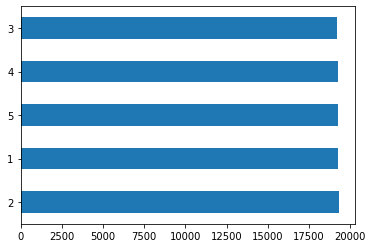

In [116]:
# Amount bins
AMOUNT = True
if AMOUNT:
  final['amount_cat'] = pd.qcut(final.Amount, q=5,labels=[1,2,3,4,5])
  
  final['amount_cat'].value_counts().plot(kind='barh')
  plt.show()
  
  qcut_series, qcut_intervals = pd.qcut(final.Amount, q=5,labels=[1,2,3,4,5],retbins=True)
  qcut_series.value_counts()

In [117]:
numvars_new = len(final.columns)- 19 - numvars
numvars = len(final.columns) - 19
print("new variables:",numvars_new,"  total variables:",numvars)

new variables: 1   total variables: 2155


In [118]:
# acceleration
for ent in attributes:
  print(ent)
  for d in ['0', '1']:
    for dd in ['7', '14', '30']:
      final[ent + '_count_' + d + '_by_' + dd + "_sq"] = final[ent + '_count_' + d]/(final[ent + '_count_' + dd])/pow(float(dd),2)


Cardnum
Merchnum
Merch description
Merch state
Merch zip
cardnum_merchnum
cardnum_merchzip
cardnum_merchdescription
cardnum_merchstate
merchnum_merchstate
merchnum_merchdescription
cardnum_amount
merchnum_cardnum_amount


In [119]:
numvars_new = len(final.columns)- 19 - numvars
numvars = len(final.columns) - 19
print("new variables:",numvars_new,"  total variables:",numvars)

new variables: 78   total variables: 2233


In [120]:
final.shape

(96397, 2252)

In [121]:
del data

In [122]:
final.shape

(96397, 2252)

In [123]:
final.columns.to_list()
print(f'Total run time:{(time.time()-begin)/60:0.2f}min')

Total run time:237.65min


In [124]:
final.shape

(96397, 2252)

In [125]:
print('duration: ',dt.datetime.now() - start_time)

duration:  4:30:10.370880


In [126]:
final.head()

,Recnum,Cardnum,Date,Merchnum,Merch description,Merch state,Merch zip,Transtype,Amount,Fraud,...,cardnum_amount_count_0_by_30_sq,cardnum_amount_count_1_by_7_sq,cardnum_amount_count_1_by_14_sq,cardnum_amount_count_1_by_30_sq,merchnum_cardnum_amount_count_0_by_7_sq,merchnum_cardnum_amount_count_0_by_14_sq,merchnum_cardnum_amount_count_0_by_30_sq,merchnum_cardnum_amount_count_1_by_7_sq,merchnum_cardnum_amount_count_1_by_14_sq,merchnum_cardnum_amount_count_1_by_30_sq
0,1,5142190439,2010-01-01,5509006296254,FEDEX SHP 12/23/09 AB#,TN,38118.0,P,3.62,0,...,0.001111,0.020408,0.005102,0.001111,0.020408,0.005102,0.001111,0.020408,0.005102,0.001111
1,2,5142183973,2010-01-01,61003026333,SERVICE MERCHANDISE #81,MA,1803.0,P,31.42,0,...,0.001111,0.020408,0.005102,0.001111,0.020408,0.005102,0.001111,0.020408,0.005102,0.001111
2,3,5142131721,2010-01-01,4503082993600,OFFICE DEPOT #191,MD,20706.0,P,178.49,0,...,0.001111,0.020408,0.005102,0.001111,0.020408,0.005102,0.001111,0.020408,0.005102,0.001111
3,4,5142148452,2010-01-01,5509006296254,FEDEX SHP 12/28/09 AB#,TN,38118.0,P,3.62,0,...,0.001111,0.020408,0.005102,0.001111,0.020408,0.005102,0.001111,0.020408,0.005102,0.001111
4,5,5142190439,2010-01-01,5509006296254,FEDEX SHP 12/23/09 AB#,TN,38118.0,P,3.62,0,...,0.001111,0.020408,0.005102,0.001111,0.020408,0.005102,0.001111,0.020408,0.005102,0.001111


In [127]:
%%time
final.drop(columns=attributes,inplace=True)
final.head()

CPU times: user 1.65 s, sys: 1.17 s, total: 2.82 s
Wall time: 1.75 s


,Recnum,Date,Transtype,Amount,Fraud,dow,dow_risk,Cardnum_day_since,Cardnum_count_0,Cardnum_avg_0,...,cardnum_amount_count_0_by_30_sq,cardnum_amount_count_1_by_7_sq,cardnum_amount_count_1_by_14_sq,cardnum_amount_count_1_by_30_sq,merchnum_cardnum_amount_count_0_by_7_sq,merchnum_cardnum_amount_count_0_by_14_sq,merchnum_cardnum_amount_count_0_by_30_sq,merchnum_cardnum_amount_count_1_by_7_sq,merchnum_cardnum_amount_count_1_by_14_sq,merchnum_cardnum_amount_count_1_by_30_sq
0,1,2010-01-01,P,3.62,0,Friday,0.025994,0.0,1,3.62,...,0.001111,0.020408,0.005102,0.001111,0.020408,0.005102,0.001111,0.020408,0.005102,0.001111
1,2,2010-01-01,P,31.42,0,Friday,0.025994,0.0,1,31.42,...,0.001111,0.020408,0.005102,0.001111,0.020408,0.005102,0.001111,0.020408,0.005102,0.001111
2,3,2010-01-01,P,178.49,0,Friday,0.025994,0.0,1,178.49,...,0.001111,0.020408,0.005102,0.001111,0.020408,0.005102,0.001111,0.020408,0.005102,0.001111
3,4,2010-01-01,P,3.62,0,Friday,0.025994,0.0,1,3.62,...,0.001111,0.020408,0.005102,0.001111,0.020408,0.005102,0.001111,0.020408,0.005102,0.001111
4,5,2010-01-01,P,3.62,0,Friday,0.025994,0.0,2,3.62,...,0.001111,0.020408,0.005102,0.001111,0.020408,0.005102,0.001111,0.020408,0.005102,0.001111


In [128]:
%%time
final.drop(columns=['Date','Transtype','Amount'],inplace=True)
final.head()

CPU times: user 479 ms, sys: 380 ms, total: 859 ms
Wall time: 861 ms


,Recnum,Fraud,dow,dow_risk,Cardnum_day_since,Cardnum_count_0,Cardnum_avg_0,Cardnum_max_0,Cardnum_med_0,Cardnum_total_0,...,cardnum_amount_count_0_by_30_sq,cardnum_amount_count_1_by_7_sq,cardnum_amount_count_1_by_14_sq,cardnum_amount_count_1_by_30_sq,merchnum_cardnum_amount_count_0_by_7_sq,merchnum_cardnum_amount_count_0_by_14_sq,merchnum_cardnum_amount_count_0_by_30_sq,merchnum_cardnum_amount_count_1_by_7_sq,merchnum_cardnum_amount_count_1_by_14_sq,merchnum_cardnum_amount_count_1_by_30_sq
0,1,0,Friday,0.025994,0.0,1,3.62,3.62,3.62,3.62,...,0.001111,0.020408,0.005102,0.001111,0.020408,0.005102,0.001111,0.020408,0.005102,0.001111
1,2,0,Friday,0.025994,0.0,1,31.42,31.42,31.42,31.42,...,0.001111,0.020408,0.005102,0.001111,0.020408,0.005102,0.001111,0.020408,0.005102,0.001111
2,3,0,Friday,0.025994,0.0,1,178.49,178.49,178.49,178.49,...,0.001111,0.020408,0.005102,0.001111,0.020408,0.005102,0.001111,0.020408,0.005102,0.001111
3,4,0,Friday,0.025994,0.0,1,3.62,3.62,3.62,3.62,...,0.001111,0.020408,0.005102,0.001111,0.020408,0.005102,0.001111,0.020408,0.005102,0.001111
4,5,0,Friday,0.025994,0.0,2,3.62,3.62,3.62,7.24,...,0.001111,0.020408,0.005102,0.001111,0.020408,0.005102,0.001111,0.020408,0.005102,0.001111


In [129]:
final.shape

(96397, 2236)

In [ ]:
# %%time
# # this cell causes the kernel to die. I guess it requires too much memory. So I just write the vars out and dedup the columns later
# print(vars.shape)
# vars = vars.T.drop_duplicates().T
# vars.shape

In [ ]:
#%%time
#final.to_csv('vars.csv',index=False)

In [ ]:
#print('duration: ',dt.datetime.now() - start_time)
# takes about an hour on my new laptop without deduping.
# takes about 2 hours on my old laptop if I don't remove duplicate columns. Then I can run the separate remove duplicates code.

In [131]:
#dedup code
# this cell takes about 25 minutes on my new notebook
# it takes about 48 minutes on my old laptop
print(final.shape)
final = final.T.drop_duplicates().T
final.shape

(96397, 2236)


(96397, 1695)

In [132]:
%%time
final.to_csv('finalvariables.csv',index=False)

CPU times: user 1min 17s, sys: 1.12 s, total: 1min 18s
Wall time: 1min 19s


In [133]:
print('duration: ',dt.datetime.now() - start_time)

duration:  4:41:15.405308


In [135]:
# #Benford Law 
# cleaned_data = data[data['Merch description'].str.match(r"[Ff][Ee][Dd][Ee][Xx]") == False].copy()
# cleaned_data['Amount'] = cleaned_data['Amount'].astype(str)

In [ ]:
# def n_low(df):
#   return((df['Amount'].str.extract(r"([1-9])") == '1') | (df['Amount'].str.extract(r"([1-9])") == '2')).sum()

In [ ]:
# cardnums = cleaned_data.groupby('Cardnum').apply(n_low)
# cardnums['n'] = cleaned_data.groupby('Cardnum')['Amount'].count()
# cardnums['n_low'] = cleaned_data.groupby('Cardnum').apply(n_low)
# cardnums = cardnums[['n','n_low']]
# cardnums['n_high'] = cardnums['n'] - cardnums['n_low']

In [ ]:
# cardnums['n_low'] = cardnums['n_low'].replace(0,1)
# cardnums['n_high'] = cardnums['n_high'].replace(0,1)

In [ ]:
# cardnums['R'] = 1.096* cardnums['n_low'] / cardnums['n_high']
# cardnums['1/R'] = 1/cardnums['R']
# cardnums['U'] = cardnums[['R','1/R']].max(axis =1)

In [ ]:
# import math

In [ ]:
# cardnums['t'] = (cardnums['n'] -15)/3
# cardnums['U*'] = 1+ ((cardnums['U'] -1)/(1+math.e**-cardnums['t']))

In [ ]:
# cardnums.sort_values('U*', ascending = False)[0:40].to_csv('Top 40 Cardnum.csv')

In [ ]:
# merchnums = cleaned_data.groupby('Merchnum').apply(n_low)
# merchnums['n'] = cleaned_data.groupby('Merchnum')['Amount'].count()
# merchnums['n_low'] = cleaned_data.groupby('Merchnum').apply(n_low)
# merchnums = merchnums[['n','n_low']]
# merchnums['n_high'] = merchnums['n'] - merchnums['n_low']

In [ ]:
# merchnums['n_low'] = merchnums['n_low'].replace(0,1)
# merchnums['n_high'] = merchnums['n_high'].replace(0,1)

In [ ]:
# merchnums['R'] = 1.096* merchnums['n_low'] / merchnums['n_high']
# merchnums['1/R'] = 1/merchnums['R']
# merchnums['U'] = merchnums[['R','1/R']].max(axis =1)

In [ ]:
# merchnums['t'] = (merchnums['n'] -15)/3
# merchnums['U*'] = 1+ ((merchnums['U'] -1)/(1+math.e**-merchnums['t']))

In [ ]:
# merchnums.sort_values('U*', ascending = False)[0:40].to_csv('Top 40 Merchnum.csv')